## Glass Identification Dataset

İçerdiği bileşenlere göre camın kalitesi, işlevi gibi
özellikleri farklılık göstermektedir. Bu özellikleri
etkileyen kimyasal bileşenlerin oranlarının doğruluğu,
camın kullanılacağı alan için mühimdir. Projede
amaç; cam bileşenlerinin değerleri göz önünde
bulundurularak, camın kullanıldığı yedi ayrı alana
göre sınıflandırma yapmaktır.

Features:

1.	RI: Camın kırılma indisi
2.	Na: Sodyum elementi
3.	Mg: Magnezyum elementi
4.	Al: Alüminyum elementi
5.	Si: Silisyum elementi
6.	K: Potasyum elementi
7.	Ca: Kalsiyum elementi
8.	Ba: Baryum elementi
9.	Fe: Demir elementi
10.	Type: Cam tipi

Class attribute: Type


1.	Building Windows Float Processed (float glass)
2.	Building Windows Non Float Processed 
3.	Vehicle Windows Float Processed (float glass)
4.	Vehicle Windows Non Float Processed (veri kümesinde bulunmamaktadır)
5.	Containers 
6.	Tableware 
7.	Headlamps


In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#SMOTE 
import imblearn
from imblearn.over_sampling import SMOTE

#LDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

## Veri kümesinin yüklenmesi

pandas kütüphanesinde yer alan read_csv() metodu ile veri seti okunup, head() ile ilk 5 örneği gösterilmektedir.

In [2]:
data = pd.read_csv('glass_dataset.csv')
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### info() metodu ile veri kümesindeki örnek sayısı, veri tiplerinin ne olduğu gibi özellikler gösterilmektedir.
Veri kümesinde 214 örnek bulunmaktadır. Öz niteliklerin veri tiplerinin float64, sınıf özelliğinin veri tipinin int64 olduğu görülmektedir.

In [3]:
#get information about the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


## Eksik değerlerin kontrolü
### Veri kümesinde eksik değerler problem oluşturabilir bu nedenle sınıflandırma yapmadan önce eksik değerlerin gerekli yöntemlerle giderilmesi gerekmektedir.
isnull() ile veri kümesi içerisinde null değer olup olmadığı kontrol edilmektedir. Veri kümesinde null değer bulunmamaktadır.

In [4]:
data.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

### Verilerin genel istatiksel sonuçları veri kümesi hakkında bazı çıkarımlarda bulunmamıza yarayabilir.
describe() ile verilerin; ortalama değerleri, standart sapma değerleri, özellik içerisinde yer alan minimum değer gibi birçok bilgi gösterilmektedir.
En yüksek ortalama değerinin Si özelliğinde olduğu görülmektedir.

In [5]:
#veri kümesi ile ilgili istatiksel bilgiler
data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


## Tekrarlanan değerlerin kontrolü
#### Veri kümesinde tekrarlanan veriler olup olmadığı kontrol edilmelidir. Tekrarlanan veriler modelin doğru sonuçlar vermesini engelleyebilir.
duplicated() metodu ile veri setinde tekrar eden değer olup olmadığı kontrol edilmektedir. Kontrol sonucunda 1 örneğin tekrar ettiği saptanmıştır.

In [6]:
#duplicated() true veya false değer döndürmektedir
dups = data.duplicated()
print('Number of duplicate rows: %d' % dups.sum())

Number of duplicate rows: 1


### Tekrarlanan değerler veri kümesinden drop_duplicates() metodu ile kaldırılmıştır.
İşlem sonucunda veri kümesinde 213 adet örnek kalmıştır.

In [7]:
#tekrarlanan veri silme
print('Number of rows before discarding duplicates = %d' % data.shape[0])
data2 = data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % data2.shape[0])

Number of rows before discarding duplicates = 214
Number of rows after discarding duplicates = 213


## Veri kümesi dengesizliğinin kontrolü
#### Sınıfların eşit dağılmadığı, her sınıf için yaklaşık olarak aynı sayıda verinin olmadığı kümelere dengesiz veri kümesi denmektedir. Dengesiz veri kümesi problemi, oluşturulan modelin yüksek accuracy değeri vermesine karşılık, confusion matrix incelendiğinde çıkan yüksek doğruluk oranının büyük bir kısmının belli bir sınıftan kaynaklandığının görülmesine neden olabilmektedir. Bu tür problemlerin giderilmesi için veri dengesizliğini ortadan kaldırmak daha doğru sonuçlar almamızı sağlamaktadır. 
value_counts() metodu ile her cam türü için ne kadar örnek olduğu gösterilmektedir. Type 2 ve Type 1'in diğer tiplere göre daha fazla örnek bulundurduğu görülmektedir.

In [8]:
data2.Type.value_counts()

2    76
1    69
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

Text(0.5, 1.0, 'Cam Turlerinin Sayisi')

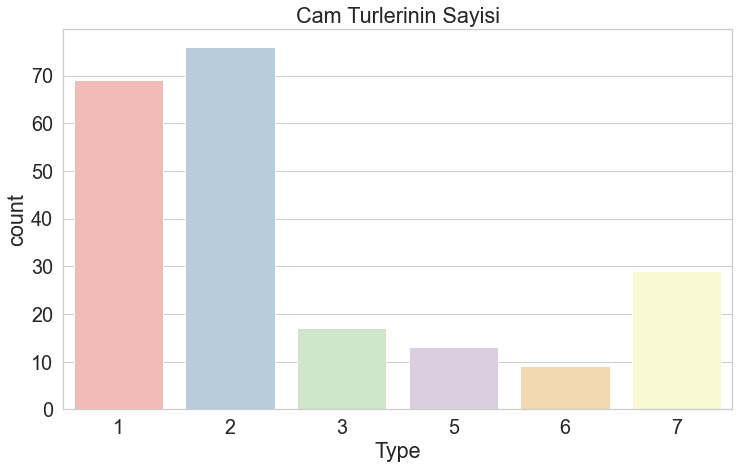

In [9]:
#grafik üzerinde gösterimi
sns.set(style = 'whitegrid', font_scale = 1.8)
plt.subplots(figsize = (12,7))
sns.countplot(x = 'Type', data = data2, palette = 'Pastel1').set_title('Cam Turlerinin Sayisi')

## Aykırı değerlerin kontrolü (outliers)
#### boxplot yardımı ile özelliklerin cam türlerine göre dağılımı gösterilmektedir. 
Genel olarak 2. cam tipi her özellik için aykırı değerler taşımaktadır.


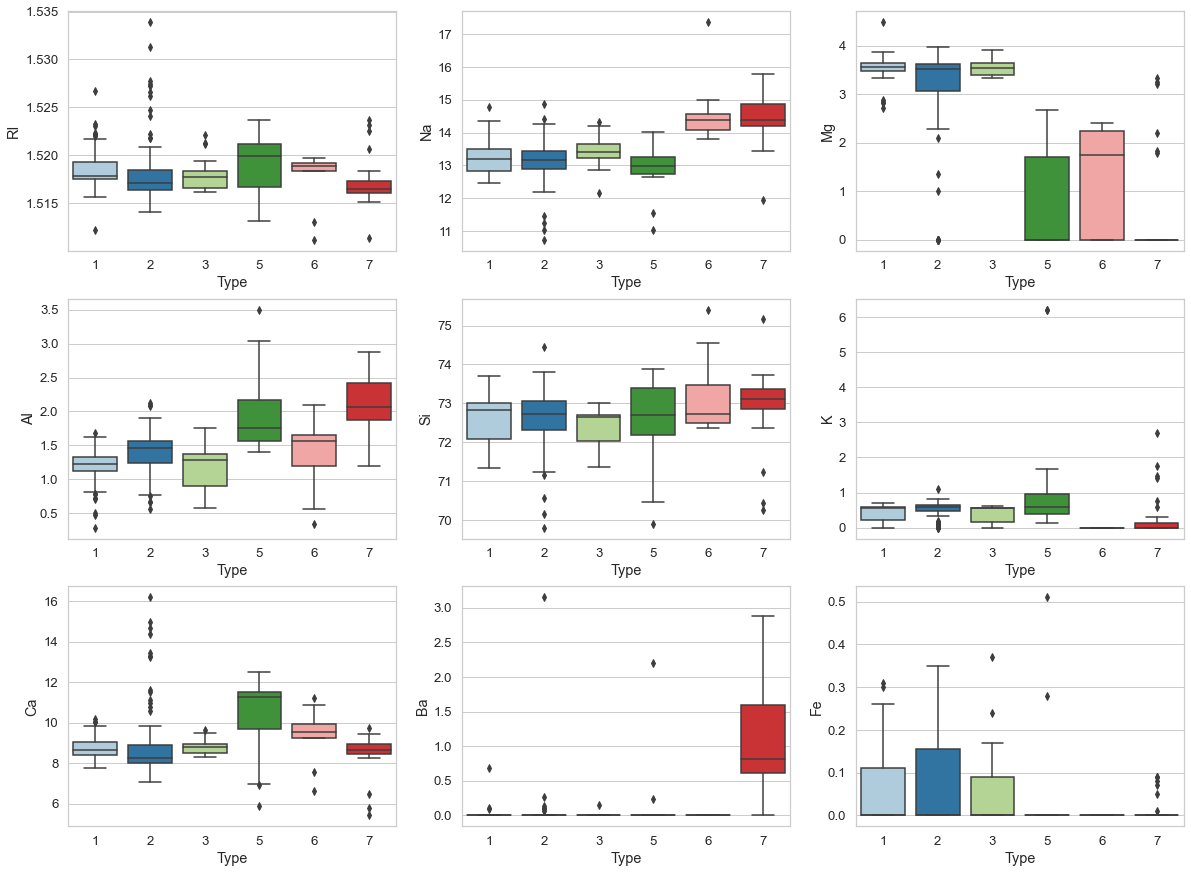

In [10]:
#outliers (aykiri veriler) 
target_class_name = 'Type'
features = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

sns.set(style = 'whitegrid', font_scale = 1.2, palette = 'Paired')
plt.subplots(figsize = (20,15))

for i in range(1,10):
    plt.subplot(3,3,i)
    sns.boxplot(x = target_class_name, y = features[i-1], data = data2)


## Özellikler arasındaki korelasyon katsayılarının belirlenmesi
Korelasyon iki değişken arasındaki ilişkiyi ifade etmektedir. 0.70, 0.80 üzeri değerler yüksek korelasyonun olduğunu göstermektedir. Veri setinde yüksek korelasyona sahip özelliklerin bulunması model için yanıltıcı olabilmektedir. Model uygulanırken, özellik seçimine dikkat edilmelidir. 
##### Veri setinde Ca elementi ile camın kırılganlık indisi (RI) arasında 0.81 değerinde yüksek korelasyon mevcuttur.
##### Ba - Al arasında 0.48
##### Ba - Na arasında 0.33
##### Si ile camın kırılganlık indisi arasında -0.54 değeri ile negatif yönde bir korelasyon söz konusudur.


<AxesSubplot:>

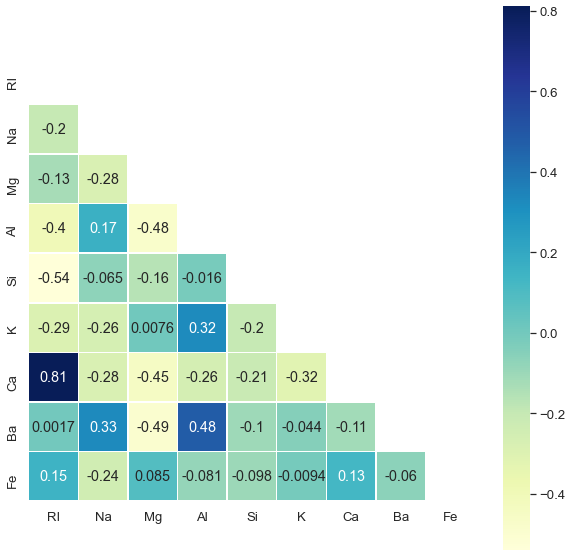

In [11]:
#korelasyon matrisi
correlation = data2[features].corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize = (10, 10))
sns.heatmap(correlation, mask = mask, cmap = 'YlGnBu', annot = True, linewidth = .5, square = True)

## Veri kümesinde bulunan öz nitelikler X değişkenine, sınıf özelliği ise y değişkenine atanmıştır.
X, y kullanılarak veriler; %80 eğitim (train) ve %20 test verileri olmak üzere ayarlanmıştır.

In [12]:
X = pd.DataFrame(data2.drop(["Type"], axis = 1),
            columns=['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe'])
y = data2.Type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 40, stratify = y)

## K-En Yakın Komşu Sınıflandırması (K-Nearest Neighbors Classification)
Yaygın olarak kullanılan bir gözetimli makine öğrenmesi algoritmasıdır. Algoritmanın çalışmasında bir k değeri belirlenir, k değerinin anlamı bakılacak eleman sayısıdır. Bir değer geldiğinde en yakın k kadar eleman alınarak gelen değer arasındaki uzaklık hesaplanır. Uzaklık hesaplama için Öklid, Manhattan, Minkowski ve Hamming fonksiyonları kullanılır. Uzaklıklar hesaplandıktan sonra sıralanır ve gelen değer uygun olan sınıfa atanır.

Uygulanan işlemlerden sonra KNN algoritması yardımı ile bir model oluşturulmuştur. GridSearchCV yardımı ile modele verilmesi gereken komşu sayısının (1, 50) aralığındaki en iyi değeri hesaplandıktan sonra accuracy 0.7674 olarak hesaplanmıştır.


In [13]:
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': np.arange(1,50)}
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10).fit(X_train, y_train)

In [14]:
n_neig = knn_cv_model.best_params_['n_neighbors']

In [15]:
knn_tuned = KNeighborsClassifier(n_neighbors = n_neig).fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score for KNN: {}'.format(knn_accuracy))

Accuracy score for KNN: 0.7674418604651163


### Accuracy değeri modelde doğru tahmin edilen alanların toplam veri kümesine oranı ile hesaplanmaktadır. 

Özellikle eşit dağılmayan veri kümelerinde bu değer tek başına yeterli değildir. Bu nedenle diğer metriklerin sonuçlarını da birlikte değerlendirmek gerekir.

## Confusion Matrix


Bu nedenle sınıflama modellerinin başarısını ölçen metriklerin hesaplanmasını sağlayan karmaşıklık matrisi oluşturulmuştur.
Her sınıf için True Positive, False Positive, False Negative ve True Negative değerleri matris üzerinden bulunmaktadır.

##### Sınıf 1: TP = 12, FP = 7, FN = 2, TN = 22
##### Sınıf 2: TP = 9, FP = 2, FN = 6, TN = 26
##### Sınıf 3: TP = 1, FP = 1, FN = 2, TN = 41
##### Sınıf 5: TP = 3, FP = 0, FN = 0, TN = 40
##### Sınıf 6: TP = 2, FP = 0, FN = 0, TN = 41
##### Sınıf 7: TP = 6, FP = 0, FN = 0, TN = 37


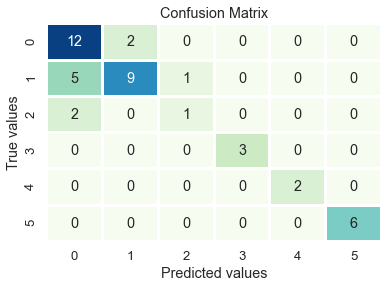

In [16]:
#Confusion Matrix of KNN
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, lw = 2, cbar = False, cmap = 'GnBu')
plt.ylabel('True values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix')
plt.show()

#### Accuracy değeri tek başına yeterli olmadığı için, precision (kesinlik), recall (duyarlılık) ve f1-score değerlerinin sonuçları classification_report() metodu ile gösterilmektedir. 


Precision değeri positive olarak tahmin edilen değerlerin gerçekten kaç tanesinin positive olduğunu göstermektedir.

Recall değeri ise positive olarak tahmin etmemiz gereken işlemlerin ne kadarını positive olarak tahmin ettiğimizi göstermektedir.

F1-score değeri ise precision ve recall değerlerinin harmonik ortalamasını göstermektedir. 

In [17]:
#Classification report for KNN
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.63      0.86      0.73        14
           2       0.82      0.60      0.69        15
           3       0.50      0.33      0.40         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6

    accuracy                           0.77        43
   macro avg       0.82      0.80      0.80        43
weighted avg       0.78      0.77      0.76        43



## SMOTE (Synthetic Minority Over-sampling Technique) ile over-sampling işlemi

Veri kümesindeki dengesizliği giderebilmek için kullanabilecek yöntemlerden biri örnekleme (resampling) işlemidir. İki yöntemi mevcuttur:

İlk yöntem azınlık sınıflarına ait verileri çeşitli yöntemlerle arttırarak eşit sayıda veriye sahip sınıflar elde etmektir. Oversampling olarak adlandırılır.

Bir diğer yöntem ağırlıklı sınıfa ait verileri veri kümesinden çıkararak dengeli bir veri kümesi elde etmektir. Undersampling işlemi olarak geçmektedir.

Kullanılan veri kümesinde örnek sayısı az olduğu ve undersampling işlemi veri kaybına yol açacağı için oversampling yöntemi tercih edilmiştir. Bu yöntemi uygulayabilmek için imbalanced-learn kütüphanesinde yer alan SMOTE tekniği kullanılıp azınlık sınıflarına ait sentetik veriler üretilmiştir. 


Azınlık sınıfına ait her gözlemin k yakın komşusu aranır. Gözlem ile k yakın komşusu olan gözlem arasındaki fark alınır, (0,1) arasında rastgele bir sayı seçilir ve fark ile çarpılır. 

#### SMOTE işlemi gerçekleştirilmeden önce sınıf dağılımları grafik üzerinde gösterilmektedir. 

Sınıf 1 için 69 örnek,
Sınıf 2 için 76 örnek,
Sınıf 3 için 17 örnek,
Sınıf 5 için 13 örnek,
Sınıf 6 için 9 örnek ve sınıf 7 için 29 örnek bulunmaktadır.

Text(0.5, 1.0, 'Before SMOTE')

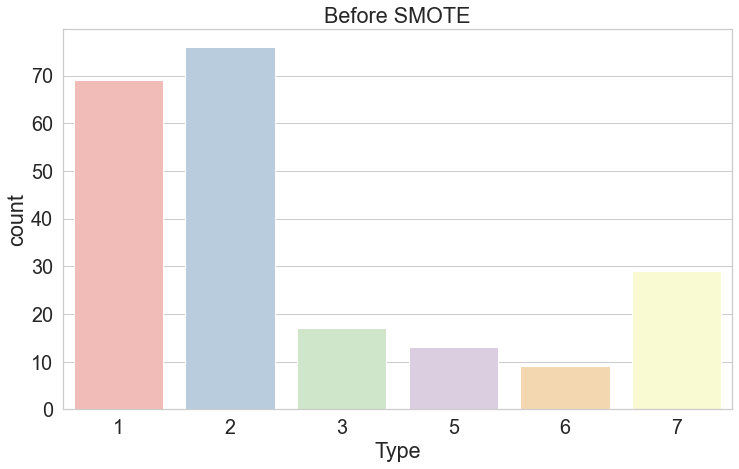

In [18]:
sns.set(style = 'whitegrid', font_scale = 1.8)
plt.subplots(figsize = (12,7))
sns.countplot(x = y, palette = 'Pastel1').set_title('Before SMOTE')

Text(0.5, 1.0, 'After SMOTE')

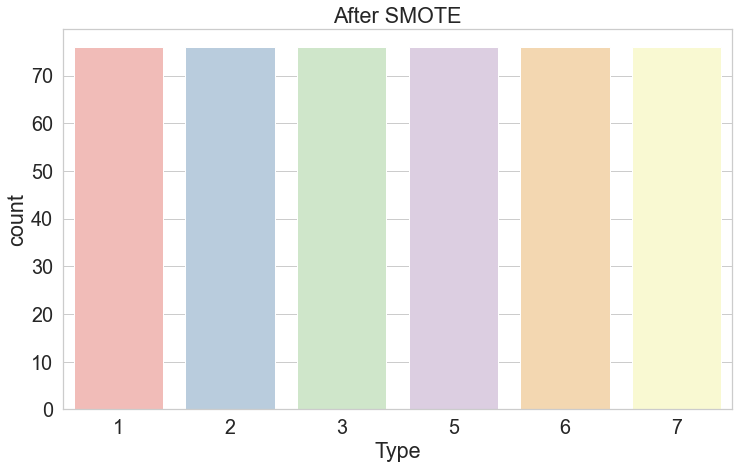

In [19]:
sm = SMOTE(sampling_strategy = 'not majority', random_state = 42)
x_res, y_res = sm.fit_resample(X, y)
y_res_df = pd.DataFrame(y_res)


sns.set(style = 'whitegrid', font_scale = 1.8)
plt.subplots(figsize = (12,7))
sns.countplot(x = y_res_df.Type, palette = 'Pastel1').set_title('After SMOTE')

In [20]:
print(x_res.shape)
print(y_res.shape)

(456, 9)
(456,)


### SMOTE uygulandıktan sonra 213 olan toplam veri sayımız 456'ya yükselmiştir.

Tüm sınıfların örnek sayısı 76 olmak üzere eşitlenmiştir.

In [21]:
y_res.value_counts()

7    76
6    76
5    76
3    76
2    76
1    76
Name: Type, dtype: int64

In [22]:
#x_res.iloc[400:456]

In [23]:
#y_res.iloc[400:455]

## Özellik Ölçeklendirme (Standard Scaler)

Verinin dağılımı, özellikler arasındaki ölçek farklılıkları gibi durumlar algoritmaların çalışmasını etkileyen faktörlerdir. Bu durumda özelliklerin ortak bir veri aralğına çekilmesi daha doğru sonuçlar elde etmemizi sağlamaktadır.


Standardizasyon; ortalama değerin 0, standart sapmanın ise 1 değerini aldığı, dağılımın normale yaklaştığı bir metoddur. 


In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size = .2, random_state = 40, stratify = y_res)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## LDA (Linear Discriminant Analysis)

Boyut azaltma tekniği olarak kullanılmaktadır. Sınıflar arasındaki farkı maksimize ederek veri setinde boyut indirger. Amaç, overfitting durumunu önlemek ve hesaplama maliyetlerini azaltmaktır.

Veri setinde 9 öz nitelik LDA yardımı ile anlamlı 5 bileşene indirgenmiştir.



In [25]:
lda = LDA(n_components = 5)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(364, 5)
(92, 5)


## K-Nearest Neighbors Classification

In [26]:
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': np.arange(1,50)}
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10).fit(X_train, y_train)
n_neighbor = knn_cv_model.best_params_['n_neighbors']

In [27]:
knn_tuned = KNeighborsClassifier(n_neighbors = n_neighbor).fit(X_train,y_train)
knn_y_pred = knn_tuned.predict(X_test)
knn_acc = accuracy_score(y_test, knn_y_pred)
print('Accuracy score for KNN: {}'.format(knn_acc))

Accuracy score for KNN: 0.8478260869565217


##### Sınıf 1: TP = 12, FP = 9, FN = 4, TN = 68
##### Sınıf 2: TP = 7, FP = 2, FN = 8, TN = 75
##### Sınıf 3: TP = 13, FP = 3, FN = 2, TN = 74
##### Sınıf 5: TP = 16, FP = 0, FN = 0, TN = 76
##### Sınıf 6: TP = 15, FP = 0, FN = 0, TN = 77
##### Sınıf 7: TP = 15, FP = 0, FN = 0, TN = 77

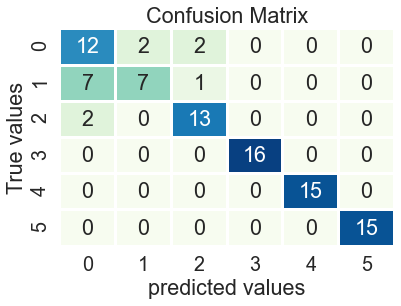

In [28]:
#Confusion Matrix of KNN
sns.heatmap(confusion_matrix(y_test, knn_y_pred), annot = True, lw = 2, cbar = False, cmap = 'GnBu')
plt.ylabel('True values')
plt.xlabel('predicted values')
plt.title('Confusion Matrix')
plt.show()

In [29]:
#Classification report for KNN
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           1       0.57      0.75      0.65        16
           2       0.78      0.47      0.58        15
           3       0.81      0.87      0.84        15
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15

    accuracy                           0.85        92
   macro avg       0.86      0.85      0.85        92
weighted avg       0.86      0.85      0.84        92

